In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("talk")
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from collections import Counter
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error,r2_score
import lightgbm as lgb

In [2]:
DATA_FOLDER = '../readonly/final_project_data/'

transactions = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))


In [3]:
dataset=(transactions
 .merge(items.drop(columns="item_name"),how="left")
 .assign(month=lambda x: x.eval("date_block_num%12+1"),year=lambda x: (x.date_block_num/12+2013).astype(int))
 .drop(columns="date")

)

In [4]:
dataset

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,month,year
0,0,59,22154,999.000,1.000,37,1,2013
1,0,25,2552,899.000,1.000,58,1,2013
2,0,25,2552,899.000,-1.000,58,1,2013
3,0,25,2554,1709.050,1.000,58,1,2013
4,0,25,2555,1099.000,1.000,56,1,2013
5,0,25,2564,349.000,1.000,59,1,2013
6,0,25,2565,549.000,1.000,56,1,2013
7,0,25,2572,239.000,1.000,55,1,2013
8,0,25,2572,299.000,1.000,55,1,2013
9,0,25,2573,299.000,3.000,55,1,2013


In [ ]:
dataset.query("year>2013")[["item_id","date_block_num","item_price"]]

Items can be mean-encoded by taking their mean and std, some products are highly variable. And then, within each shop, we will also include the same features

In [5]:
aggregated_data=(dataset
                 
.drop(columns=["year","item_price","month","item_category_id"])
 
.groupby(["date_block_num","shop_id","item_id"]).sum()
 .reset_index()
 .assign(item_cnt_day=lambda x: np.clip(x.item_cnt_day,0,20))
)

In [56]:
preX=(aggregated_data
.assign(month=lambda x: x.eval("date_block_num%12+1"),year=lambda x: (x.date_block_num/12+1).astype(int))
 .merge(items.drop(columns="item_name"),how="left")

)
def get_past_month(aggvars,name,back):
    return (preX.groupby(aggvars)
     .item_cnt_day.sum().reset_index()
     .assign(date_block_num=lambda x: x.date_block_num+back)
     .rename(columns={"item_cnt_day":name+str(back)})
    )

def get_agg_past_month(back):
    return (preX.groupby(["shop_id","date_block_num","item_category_id"])
            .item_cnt_day.mean().reset_index()
             .assign(date_block_num=lambda x: x.date_block_num+back)
            .rename(columns={"item_cnt_day":"pmonth_c"+str(back)})
           )
pmonth=get_past_month(["item_id","shop_id","date_block_num"],"pmonth",1)
pmonth2=get_past_month(["item_id","shop_id","date_block_num"],"pmonth",2)
pmonth3=get_past_month(["item_id","shop_id","date_block_num"],"pmonth",3)


pmonth_c=get_agg_past_month(1)
pmonth2_c=get_agg_past_month(2)
pmonth3_c=get_agg_past_month(3)


names=["pmonth","pmonth_c"]
past=[]
for i in [1,2,3]:
    for j in names:
        past.append(j+str(i))
        
names2=["pmonth"]
past2=[]
for i in [1,2,3]:
    for j in names2:
        past2.append(j+str(i))
        
preX2=(preX
       .merge(pmonth,how="left")
       .merge(pmonth2,how="left")
       .merge(pmonth3,how="left")

       
       .merge(pmonth_c,how="left")
       .merge(pmonth2_c,how="left")
       .merge(pmonth3_c,how="left")

       
       .drop(columns=["shop_id","item_id","item_category_id"])
      )
#preX2[past]=preX2[past].fillna(0)
preX2=preX2.query("date_block_num>3")

#preX2=preX2.sample(frac=1,replace=False)


In [39]:
def normalise_all(x):
    shape=x.shape[0]
    return np.where(np.isnan(x[past].values),
             np.nanmean(x[past].values,axis=1).reshape(shape,1),
             x[past].values)

def normalise_rolling_mean(x):
    shape=x.shape[0]
    return np.where(np.isnan(x[past2].values),
             np.nanmean(x[past2].values,axis=1).reshape(shape,1),
             x[past2].values)

In [34]:
#preX2[past2]=normalise_rolling_mean(preX2)
#preX2[past]=normalise_all(preX2)

/home/jose/scratch/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


In [57]:
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures()

validation="(year==3 and month in [10,9,8])"
preX2.dropna(inplace=True)
#preX2.dropna(inplace=True)
X_val = preX2.query(validation).drop(
    columns=["item_cnt_day","date_block_num"])
y_val = preX2.query(validation).item_cnt_day

training="not "+validation
X_train = preX2.query(training).drop(
    columns=["item_cnt_day","date_block_num"])
y_train = preX2.query(training).item_cnt_day

#X_train=poly.fit_transform(X_train)
#X_val=poly.fit_transform(X_val)

X_train.shape

(226296, 8)

In [58]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

lr=LinearRegression()
lr.fit(X_train,y_train)
display(lr.score(X_train,y_train))
y_pred=np.clip(lr.predict(X_train),0,20)
np.sqrt(mean_squared_error(y_train,y_pred))

0.52811696684238618

2.4014840280217506

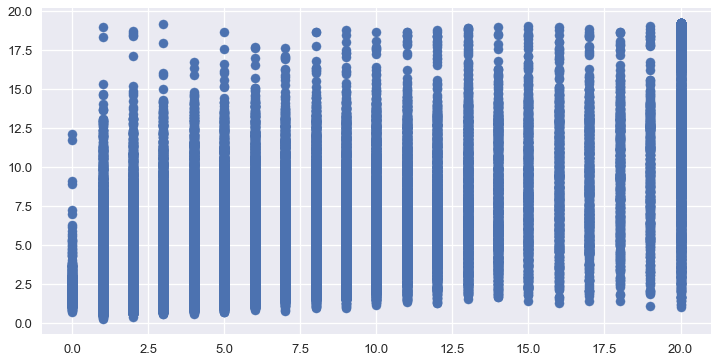

In [59]:
plt.scatter(y_train,y_pred)

## Keras

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, PReLU
from keras import backend as K
from keras import optimizers
import keras


def rmse(y_true, y_pred):
    mse = K.sqrt(K.mean(K.square(y_pred - y_true)))
    return mse


def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))


def clipped_linear(x):
    return K.clip(x, 0, 20)


model = Sequential([
    Dense(128, input_shape=(8,)),
    BatchNormalization(),
    Activation("relu"),
    BatchNormalization(),
    Dense(128),
    Activation("relu"),
    BatchNormalization(),
    Dense(128),
    Activation("relu"),
    BatchNormalization(),
    Dense(128),
    Activation("relu"),
    BatchNormalization(),

    Dense(1, activation=clipped_linear)
])
sgd = optimizers.Adam()
model.compile(optimizer=sgd,
              loss=rmse,
              metrics=[coeff_determination],
              )
model.fit(X_train, y_train, epochs=9, batch_size=2048,
          validation_data=(X_val, y_val))

Train on 226296 samples, validate on 15017 samples
Epoch 1/9
226296/226296 [==============================] - 2s 10us/step - loss: 2.6181 - coeff_determination: 0.4303 - val_loss: 2.4975 - val_coeff_determination: 0.4775
Epoch 2/9
226296/226296 [==============================] - 1s 6us/step - loss: 2.4137 - coeff_determination: 0.5213 - val_loss: 2.3383 - val_coeff_determination: 0.5431
Epoch 3/9
226296/226296 [==============================] - 1s 6us/step - loss: 2.3733 - coeff_determination: 0.5368 - val_loss: 2.3548 - val_coeff_determination: 0.5364
Epoch 4/9
226296/226296 [==============================] - 1s 6us/step - loss: 2.3505 - coeff_determination: 0.5465 - val_loss: 2.3315 - val_coeff_determination: 0.5455
Epoch 5/9
226296/226296 [==============================] - 2s 7us/step - loss: 2.3382 - coeff_determination: 0.5503 - val_loss: 2.3214 - val_coeff_determination: 0.5496
Epoch 6/9
226296/226296 [==============================] - 1s 6us/step - loss: 2.3298 - coeff_determina

## Predict for training set

In [65]:
X_test=(test
.assign(date_block_num=34,month=11,year=3)
.merge(items.drop(columns="item_name"),how="left")

 #.drop(columns=["shop_id","item_id","item_category_id"]) 
).drop(columns="ID")

pmonth=get_past_month(["item_id","shop_id","date_block_num"],"pmonth",1)
pmonth2=get_past_month(["item_id","shop_id","date_block_num"],"pmonth",2)
pmonth3=get_past_month(["item_id","shop_id","date_block_num"],"pmonth",3)


pmonth_c=get_agg_past_month(1)
pmonth2_c=get_agg_past_month(2)
pmonth3_c=get_agg_past_month(3)
pmonth4_c=get_agg_past_month(4)

names=["pmonth","pmonth_c"]
past=[]
for i in range(1,5):
    for j in names:
        past.append(j+str(i))

preX2=(X_test
       .merge(pmonth,how="left")
       .merge(pmonth2,how="left")
       .merge(pmonth3,how="left")

       
       .merge(pmonth_c,how="left")
       .merge(pmonth2_c,how="left")
       .merge(pmonth3_c,how="left")

       
       .drop(columns=["shop_id","item_id","item_category_id"])
      )



      
#preX2[past]=preX2[past].fillna(0)



In [135]:
preX2

,date_block_num,month,year,pmonth1,pmonth2,pmonth3,pmonth_c1,pmonth_c2,pmonth_c3
0,34,11,3,nan,1.000,3.000,1.705,2.245,2.537
1,34,11,3,nan,nan,nan,1.191,1.120,1.183
2,34,11,3,1.000,3.000,1.000,1.705,2.245,2.537
3,34,11,3,nan,nan,1.000,1.410,1.853,1.810
4,34,11,3,nan,nan,nan,3.600,2.421,2.425
5,34,11,3,1.000,1.000,nan,1.410,1.853,1.810
6,34,11,3,2.000,3.000,nan,3.600,2.421,2.425
7,34,11,3,nan,nan,nan,1.191,1.120,1.183
8,34,11,3,nan,3.000,2.000,1.191,1.120,1.183
9,34,11,3,nan,nan,nan,3.600,2.421,2.425


In [180]:
y_pred=preX2.pmonth1.to_frame()
y_pred.index=preX2.index

In [181]:
y_pred_nn=model.predict(preX2.drop(columns=["date_block_num"]).dropna())

In [182]:
y_pred.loc[preX2.dropna().index,"nn"]=y_pred_nn.ravel()

In [183]:
y_pred_final=y_pred.assign(final=lambda x: x.dropna().mean(axis=1)).final.fillna(0).to_frame()
#y_pred_final=y_pred.assign(final=lambda x: np.where(~pd.isnull(x.nn),x.nn,x.pmonth1))

In [186]:
results=pd.DataFrame({"ID":test.ID,"item_cnt_month":y_pred_final.final})
results.to_csv("naively_nn_05mean.csv.gz",compression="gzip",index=False)

In [187]:
results

,ID,item_cnt_month
0,0,0.500
1,1,0.500
2,2,1.716
3,3,0.500
4,4,0.500
5,5,0.500
6,6,0.500
7,7,0.500
8,8,0.500
9,9,0.500
